This script generates visualizations of 15mer hits and 9mers hits.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import AlignIO
from Bio import SeqIO
import numpy as np
import seaborn as sns

In [3]:
def extract_ordered_nmers(uniprot, prot_dict, length):
    #############
    # Generate 'length'-mer peptides from whole proteome.
    #############
    # Uniprot: protein's uniprot identifier; used to look up protein sequencein prot_dict
    # prot_dict: dictionary of protein uniprot ID pointing to protein sequence
    # length: length of peptides in screen; unit length for proteome to be divided into
    ############
    mers = []
    order = []
    source=[]
    seq = prot_dict[uniprot].seq
    for i in range(0,len(seq)-(length-1)):
        mers.append(str(seq[i:i+length]))
        order.append(i+1)
        source.append(uniprot)
    df = pd.DataFrame({'{}mers'.format(length):mers, 'order':order,'source':source})
    return df


def merge_proteomes_datasets(protein_df,data,naming,mhc):
    #############
    # Align dataframe containing 15mers from proteome with the dataset of enrichment values for all 15mers.
    # Call peptides as hits or not based on enrichment in doped and undoped libraries.
    #############
    # protein_df: dataframe containing all 15mers from proteome in order (columns: '15mers', 'order', 'source')
    # data: dataframe containing yeast display experiment data
    # naming: 'covid' or 'dengue' or 'netmhc'; determines which column headers to use for calculations
    ############
    
    # Merge list in order with dataset 
    merged = pd.merge(left=protein_df, right=data,left_on='15mers',right_on='name',how='left')
    merged
       
    
    # Define hits: Keep hits above thresholds - indicate hits
    if naming == 'covid':
        print('in covid section')
        ## COVID Naming
        #hit using undoped
        merged['hit u'] = merged['frac_ undoped-{} post-R2 - positive '.format(mhc)]>merged['frac_ undoped-{} post-R1 - positive '.format(mhc)]

        #hit using doped
        merged['hit d'] = (merged['count_ doped-{} post-R3 '.format(mhc)]>=10)

        #hit using undoped and doped
        merged['hit d+u'] = (merged['hit d']&merged['hit u'])
    
    elif naming == 'dengue': #doped hit based on rep 1
        print('in dengue section')
        ## Dengue Naming
        #hit using undoped
        merged['hit u'] = merged['{}-R2-pos_undoped_frac'.format(mhc)]>merged['{}-R1-pos_undoped_frac'.format(mhc)]

        #hit using doped
        merged['hit d'] = (merged['R3-{}_doped-rep1'.format(mhc)]>=10) # Rep1 only

        #hit using undoped and doped
        merged['hit d+u'] = (merged['hit d']&merged['hit u'])
               
    elif naming == 'netmhc':
        print('in netmhc section')
        merged['hit d+u'] = (merged['Rank DRB1_0401']<=10) 
  
    # make a column that's variation of 'hit d+u' - if 'true', value is between 1-15 (offset so neighboring peptides are different for later visualization)
    merged['hit mod_value'] = 0
    merged.loc[merged['hit d+u']==1, 'hit mod_value'] = merged.loc[merged['hit d+u']==1, 'order']%15+1

    return (merged)


def trace_hits_over_aas_dropped(df, data_merged, p1_kw=False, p1_col_name=''):
    ############
    # For each 15mer hit in proteome, mark all 15 amino acids in it as hits.
    # Alternatively, mark P1 location.
    # Drop lines down to lowest y-value without causing overlap (like turning 'gravity' on)
    # This is in a 'vertical' type format, where the proteome is stretched across all rows, 1 amino acid at a time.
    ############
    # df: (df_1mers) dataframe containing all '1mers' (single amino acids) from proteome in order (columns: '1mers', 'order', 'source')
    # data_merged: dataframe containing yeast display experiment data, merged with analytical data, including 'hit mod_value', a variation of 'hit d+u'
    # p1_kw: if 'True', mark only the P1.
    # p1_col_name: required if p1_kw==True, to use correct column in data_merged
    ############
    
    df_1mers = df.copy(deep=True)

    for i in range(1,16):
        df_1mers['mod={}'.format(str(i))]=0

    mod_val = 0 # use a moving 'mod value' that increases where at in y-dimension so don't overlap other hits ('mod_val' is basically how much y-offset to use in figure)
    gaps = 0 # count space between last hit so can drop back to 0
    for i in range(0,len(data_merged)):
        if data_merged.loc[data_merged['order']==i+1,'hit mod_value'].values>0:
            if gaps>= 14: #if big gaps between the last hit and this hit, can start back at the bottom without overlapping
                mod_val = 0
            elif mod_val >= 15: #if have 15 or more overlapping peptides, can start back at bottom without overlapping
                mod_val = 0

            gaps = 0 #reset gap to 0 when there's a hit 
            mod_val = mod_val+1
            
            # do for peptides ('normal')
            if p1_kw == False:
                df_1mers.loc[i,'mod={}'.format(str(mod_val))] = mod_val #mark the first amino acid #Alt: .loc[df_1mers['order']==i+1,...] ('order' = 'index+1')
                for neighbor_i in range(1,15): #to the next 14 amino acids, mark them as also a hit (only marked for P1 so far)
                    df_1mers.loc[i+neighbor_i,'mod={}'.format(str(mod_val))]=mod_val #Alt: .loc[df_1mers['order']==i+1+neighbor_i,...]
            # do for marking P1
            elif p1_kw == True:
                p1 = data_merged.loc[data_merged['order']==i+1, p1_col_name]
                df_1mers.loc[i+p1,'mod={}'.format(str(mod_val))]=mod_val
            
        else: #not a hit
            gaps+=1
            
    #save Y order labels as string so all must be plotted later 
    df_1mers['order_str'] = df_1mers['order'].astype(str) 
    
    #convert zeros to NaN so won't plot and can plot continuous lines
    for i in range(1,16):
        df_1mers.loc[ df_1mers['mod={}'.format(str(i)) ]==0,'mod={}'.format(str(i))]=np.nan
    
    return df_1mers



In [4]:
def rename_cols(df, serotype): # rename columns so reflect the serotype
    for col in list(df.columns):
        df = df.rename(columns={col:col+'_'+str(serotype)})
    return df

def find(s, ch): # simple search function: https://stackoverflow.com/questions/11122291/how-to-find-char-in-string-and-get-all-the-indexes
    return [i for i, ltr in enumerate(s) if ltr == ch]

def add_gaps(df, uniprot,serotype,alignment):
    ###########
    # When proteins are aligned (as in 'alignment'), there are frequently gaps from insertions/deletions in a protein.
    # This script adds gaps to dataframes ('df') of ordered peptides by moving their ordering in 'order' to 
    # new column 'order+gaps' to reflect their alignment in 'alignment'. 
    # Returns updated df with 'order+gaps' column
    ###########
    # df: dataframe containing ordered peptides
    # uniprot: uniprot ID corresponding to a protein of interest, as labelled in 'alignment'
    # alignment: alignment of proteins of interest
    # serotype: string that is in the header of df and will use in header ['order_'+serotype]
    ###########
    for record in alignment:
        if record.id == uniprot:
            aligned_seq = record.seq
            print('found sequence: ',record.id)
    gap_locations = find(aligned_seq,'-') #indexed at 0 #find the gaps
    
    df['order+gaps_'+str(serotype)]=df['order_'+str(serotype)] #order in the alignment
    for i in gap_locations:
        df.loc[df['order+gaps_'+str(serotype)]>=i+1,'order+gaps_'+str(serotype)]+=1 #increase the order by 1

    return df

def do_it(uniprot, fname,serotype,virus,data,allele,kw_skipP1=False):
    ######
    # Function to call other functions: outputs dataframes of ordered 1mers and 9mers, 
    # and 15mers merged with data from yeast display experiments
    ######
    # uniprot: uniprot name of protein of interest
    # fname: FASTA file name, containing the sequence of protein named in 'uniprot' variable
    # serotype: 1-4 for dengue or 1-2 for covid (for SARS-CoV or SARS-CoV-2)
    # virus: 'covid' or 'dengue'
    # data: dataframe of yeast data
    # allele: HLA-DR401/402/404 (401, 402, 402)
    # kw_skipP1: if False (default), will include a marking for where P1 of the cluster-identified core is
    ######
    
    prot_dict = SeqIO.to_dict(SeqIO.parse(fname, "fasta"))#Import source protein sequences ##Dictionary of the uniprot IDs and their corresponding protein sequences
    
    df_15mers = extract_ordered_nmers(uniprot, prot_dict, length=15) #15mers
    data_merged = merge_proteomes_datasets(df_15mers,data,virus,allele) #merge ordered 15mers with yeast data

    df_1mers = extract_ordered_nmers(uniprot, prot_dict, length=1) #1mers
    df_1mers = trace_hits_over_aas_dropped(df_1mers, data_merged) #mark where 15mer hits are
    
    df_9mers = extract_ordered_nmers(uniprot, prot_dict, length=9) #9mers 
 
    #highlight P1 of cores
    if kw_skipP1!=True:
        df_1mers_p1 = trace_hits_over_aas_dropped(df_1mers, data_merged, True, 'P1_{}'.format(allele))
        df_1mers_p1 = rename_cols(df_1mers_p1, 'p1')
        df_1mers = pd.merge(left=df_1mers, right=df_1mers_p1, left_on='order',right_on='order_p1')
        df_1mers = rename_cols(df_1mers, serotype)
        
    return data_merged, df_1mers, df_9mers

In [5]:
###### for 9mer smoothing ############
def NofSeven(merged, df_9mers):
    ########
    # For smoothing to 9mer sequences by determining how many neighboring 15mers a given 9mer enriches in.
    # For most peptides (excluding edge peptides), a 9mer will show up in seven 15mer peptides.
    # Uses a dataframe of 9mer peptides and notes hits there.
    ########
    # merged: dataframe of ordered 15mer peptides with yeast display enrichment information.
    # df_9mers: dataframe of ordered 9mer peptides.
    # Outputs updated df_9mers with information about how many of 7 15mers are hits.
    ########
    
    #Denote #/7 peptides present in a row
    df_9mers['n hits of 7-d+u']=0
    df_9mers['n hits of 7-d']=0
    df_9mers['n hits of 7-u']=0
    df_9mers['n hits of 7-d only']=0 #hits in doped, but not undoped
    df_9mers['n hits of 7-u only']=0 #hits in undoped, but not doped

    #Count # of peptides that 9mer has hits in for peptides (want at least 5/7 in sliding window to be hits)
    for i in range(int(np.min(df_9mers['order'])),int(np.max(df_9mers['order'])+1)): 
        #create a boolean, where 'true' is 'order' in 15mer which contain 9mer of interest
        surrounding=(merged['order']>=i-6) & (merged['order']<=i)
                
        df_9mers.loc[df_9mers['order']==i,'n hits of 7-d+u']=np.sum(merged[surrounding]['hit d+u'])
        df_9mers.loc[df_9mers['order']==i,'n hits of 7-d']=np.sum(merged[surrounding]['hit d'])
        df_9mers.loc[df_9mers['order']==i,'n hits of 7-u']=np.sum(merged[surrounding]['hit u'])
        df_9mers.loc[df_9mers['order']==i,'n hits of 7-d only']=np.sum((merged[surrounding]['hit d']) & (~merged[surrounding]['hit u']))
        df_9mers.loc[df_9mers['order']==i,'n hits of 7-u only']=np.sum((merged[surrounding]['hit u']) & (~merged[surrounding]['hit d']))
                
        if i%100 == 0:
            print(i)

    return df_9mers

# Example of 15mer hits with intermediate dataframes shown

/Users/brooke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,40,42,43,47,51,55,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sequence,count,P1
0,KDGTCGLVEVEKGVL,1,7
1,LEGIQYGRSGETLGV,1,5
2,QYGRSGETLGVLVPH,1,1
3,KHSSGVTRELMRELN,1,9
4,HSSGVTRELMRELNG,1,8
5,SSGVTRELMRELNGG,1,7
6,SGVTRELMRELNGGA,1,6
7,GVTRELMRELNGGAY,1,5
8,TRELMRELNGGAYTR,1,3
9,RELMRELNGGAYTRY,1,2


,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,count_ doped-404 post-R1,count_ doped-401 post-R2,count_ doped-402 post-R2,...,frac_ undoped-401 post-R2 - negative,frac_ undoped-402 post-R2 - negative,frac_ undoped-404 post-R2 - negative,frac_ undoped-401 post-R3 - positive,frac_ undoped-402 post-R3 - positive,frac_ undoped-404 post-R3 - positive,frac_ undoped-401 post-R3 - negative,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,P1
0,MESLVPGFNEKTHVQ,ATGGAATCACTAGTTCCTGGATTCAATGAAAAGACTCATGTTCAA,0.0,0.0,0.0,3.0,3.0,0.0,3.0,8.0,...,0.000171,0.000235,0.000117,0.000016,0.000025,0.000016,0.000149,0.000159,0.000059,NaN
1,ESLVPGFNEKTHVQL,GAGAGTTTAGTGCCTGGTTTCAACGAAAAAACCCATGTTCAGTTA,0.0,0.0,0.0,2.0,3.0,0.0,5.0,2.0,...,0.000214,0.000185,0.000215,0.000000,0.000000,0.000000,0.000050,0.000036,0.000064,NaN
2,SLVPGFNEKTHVQLS,TCACTTGTTCCCGGTTTCAACGAAAAGACACACGTACAATTATCT,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,...,0.000135,0.000178,0.000193,0.000016,0.000008,0.000012,0.000069,0.000043,0.000107,NaN
3,LVPGFNEKTHVQLSL,TTGGTACCTGGTTTCAACGAGAAAACACATGTTCAATTATCTTTG,1.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,...,0.000114,0.000178,0.000026,0.000000,0.000000,0.000000,0.000044,0.000050,0.000000,NaN
4,VPGFNEKTHVQLSLP,GTTCCAGGCTTTAACGAGAAGACCCATGTTCAATTATCTCTGCCG,0.0,0.0,0.0,0.0,25.0,1.0,0.0,7.0,...,0.000014,0.000029,0.000033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
5,PGFNEKTHVQLSLPV,CCAGGATTTAATGAAAAAACTCATGTGCAATTGAGTCTACCCGTA,0.0,0.0,0.0,0.0,3.0,20.0,0.0,2.0,...,0.000107,0.000078,0.000058,0.000000,0.000000,0.000000,0.000000,0.000014,0.000021,NaN
6,GFNEKTHVQLSLPVL,GGCTTTAATGAAAAAACACATGTACAACTTAGTCTACCAGTTCTC,0.0,0.0,0.0,0.0,6.0,3.0,0.0,4.0,...,0.000114,0.000249,0.000270,0.000016,0.000008,0.000023,0.000044,0.000079,0.000139,NaN
7,FNEKTHVQLSLPVLQ,TTCAACGAGAAGACTCATGTTCAGCTGTCTTTGCCAGTTTTGCAG,1.0,0.0,0.0,1.0,4.0,10.0,3.0,4.0,...,0.000185,0.000356,0.000496,0.000016,0.000038,0.000121,0.000106,0.000180,0.000417,NaN
8,NEKTHVQLSLPVLQV,AATGAGAAAACTCATGTCCAATTGTCATTGCCTGTTCTGCAAGTT,0.0,0.0,1.0,7.0,13.0,22.0,6.0,3.0,...,0.000199,0.000356,0.000383,0.000033,0.000025,0.000051,0.000162,0.000159,0.000294,NaN
9,EKTHVQLSLPVLQVR,GAAAAGACGCACGTGCAACTTTCATTACCGGTTCTGCAAGTTAGA,0.0,0.0,0.0,1.0,0.0,11.0,3.0,0.0,...,0.000071,0.000207,0.000091,0.000000,0.000008,0.000027,0.000037,0.000137,0.000107,NaN


,15mers,order,source
0,MSDNGPQNQRNAPRI,1,sp|P0DTC9|NCAP_WCPV
1,SDNGPQNQRNAPRIT,2,sp|P0DTC9|NCAP_WCPV
2,DNGPQNQRNAPRITF,3,sp|P0DTC9|NCAP_WCPV
3,NGPQNQRNAPRITFG,4,sp|P0DTC9|NCAP_WCPV
4,GPQNQRNAPRITFGG,5,sp|P0DTC9|NCAP_WCPV
5,PQNQRNAPRITFGGP,6,sp|P0DTC9|NCAP_WCPV
6,QNQRNAPRITFGGPS,7,sp|P0DTC9|NCAP_WCPV
7,NQRNAPRITFGGPSD,8,sp|P0DTC9|NCAP_WCPV
8,QRNAPRITFGGPSDS,9,sp|P0DTC9|NCAP_WCPV
9,RNAPRITFGGPSDST,10,sp|P0DTC9|NCAP_WCPV


,1mers,order,source
0,M,1,sp|P0DTC9|NCAP_WCPV
1,S,2,sp|P0DTC9|NCAP_WCPV
2,D,3,sp|P0DTC9|NCAP_WCPV
3,N,4,sp|P0DTC9|NCAP_WCPV
4,G,5,sp|P0DTC9|NCAP_WCPV
5,P,6,sp|P0DTC9|NCAP_WCPV
6,Q,7,sp|P0DTC9|NCAP_WCPV
7,N,8,sp|P0DTC9|NCAP_WCPV
8,Q,9,sp|P0DTC9|NCAP_WCPV
9,R,10,sp|P0DTC9|NCAP_WCPV


in covid section


,15mers,order,source,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,...,frac_ undoped-402 post-R3 - positive,frac_ undoped-404 post-R3 - positive,frac_ undoped-401 post-R3 - negative,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,P1,hit u,hit d,hit d+u,hit mod_value
0,MSDNGPQNQRNAPRI,1,sp|P0DTC9|NCAP_WCPV,MSDNGPQNQRNAPRI,ATGTCAGACAATGGTCCTCAAAACCAACGAAATGCACCGAGGATT,0.0,0.0,0.0,2.0,2.0,...,0.000000,0.000000,0.000006,0.000000,0.000000,NaN,False,False,False,0
1,SDNGPQNQRNAPRIT,2,sp|P0DTC9|NCAP_WCPV,SDNGPQNQRNAPRIT,TCAGATAACGGTCCTCAAAATCAAAGAAACGCCCCACGAATTACA,0.0,0.0,0.0,4.0,0.0,...,0.000004,0.000000,0.000025,0.000000,0.000000,NaN,False,False,False,0
2,DNGPQNQRNAPRITF,3,sp|P0DTC9|NCAP_WCPV,DNGPQNQRNAPRITF,GATAACGGTCCACAAAATCAACGTAATGCTCCTAGAATCACCTTC,0.0,0.0,0.0,0.0,0.0,...,0.000017,0.000008,0.000019,0.000014,0.000016,NaN,False,False,False,0
3,NGPQNQRNAPRITFG,4,sp|P0DTC9|NCAP_WCPV,NGPQNQRNAPRITFG,AACGGTCCACAAAACCAAAGGAACGCACCCAGAATCACTTTCGGT,0.0,0.0,0.0,5.0,0.0,...,0.000000,0.000000,0.000012,0.000000,0.000000,NaN,False,False,False,0
4,GPQNQRNAPRITFGG,5,sp|P0DTC9|NCAP_WCPV,GPQNQRNAPRITFGG,GGGCCACAGAATCAACGTAATGCGCCTAGGATTACATTTGGTGGT,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000012,0.000000,0.000000,NaN,False,False,False,0
5,PQNQRNAPRITFGGP,6,sp|P0DTC9|NCAP_WCPV,PQNQRNAPRITFGGP,CCACAAAACCAAAGAAACGCGCCGAGAATAACGTTTGGAGGGCCG,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000014,0.000000,NaN,False,False,False,0
6,QNQRNAPRITFGGPS,7,sp|P0DTC9|NCAP_WCPV,QNQRNAPRITFGGPS,CAAAATCAAAGGAACGCACCTAGAATAACATTTGGGGGTCCAAGC,0.0,0.0,0.0,6.0,0.0,...,0.000000,0.000000,0.000000,0.000007,0.000005,NaN,False,False,False,0
7,NQRNAPRITFGGPSD,8,sp|P0DTC9|NCAP_WCPV,NQRNAPRITFGGPSD,AACCAACGCAATGCGCCCAGAATTACATTTGGTGGACCTTCTGAT,0.0,0.0,0.0,0.0,2.0,...,0.000004,0.000000,0.000000,0.000022,0.000011,NaN,False,False,False,0
8,QRNAPRITFGGPSDS,9,sp|P0DTC9|NCAP_WCPV,QRNAPRITFGGPSDS,CAGAGGAACGCACCGAGAATAACCTTTGGTGGCCCTAGCGACAGT,1.0,0.0,0.0,2.0,0.0,...,0.000000,0.000000,0.000044,0.000000,0.000021,NaN,False,False,False,0
9,RNAPRITFGGPSDST,10,sp|P0DTC9|NCAP_WCPV,RNAPRITFGGPSDST,CGGAATGCTCCTCGAATTACATTTGGTGGTCCTTCCGACTCTACC,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000019,0.000007,0.000000,NaN,False,False,False,0


,1mers,order,source,mod=1,mod=2,mod=3,mod=4,mod=5,mod=6,mod=7,mod=8,mod=9,mod=10,mod=11,mod=12,mod=13,mod=14,mod=15,order_str
0,M,1,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,S,2,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,D,3,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,N,4,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,G,5,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,P,6,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,Q,7,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,N,8,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
8,Q,9,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
9,R,10,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


,1mers,order,source,mod=1,mod=2,mod=3,mod=4,mod=5,mod=6,mod=7,mod=8,mod=9,mod=10,mod=11,mod=12,mod=13,mod=14,mod=15,order_str
0,M,1,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,S,2,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,D,3,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,N,4,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,G,5,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,P,6,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,Q,7,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,N,8,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
8,Q,9,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
9,R,10,sp|P0DTC9|NCAP_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


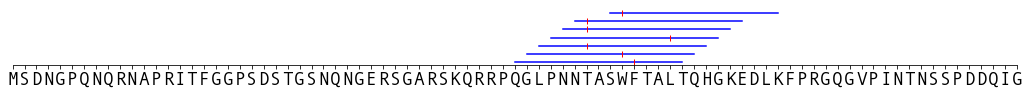

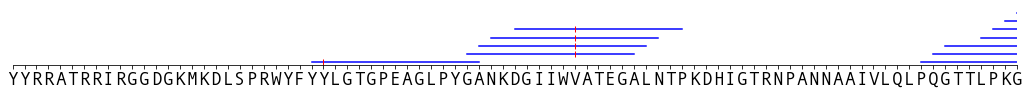

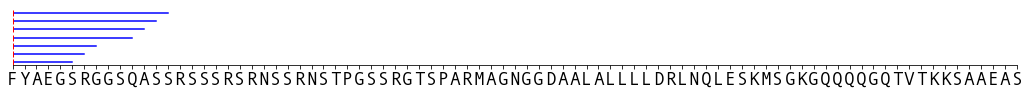

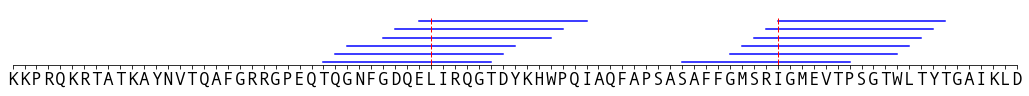

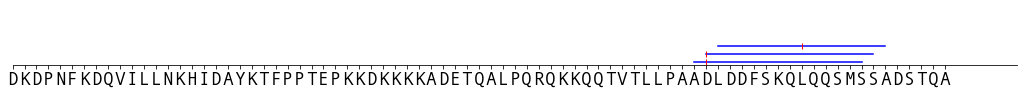

In [6]:
## SARS-CoV-2 ###
data = pd.read_csv('../twist_covid_filtered+normalized_counts.csv').fillna(0)
data.drop(columns='Unnamed: 0',inplace=True)
data.drop(columns='Unnamed: 0.1',inplace=True)
data=data[data['doped_match']!='match'] #keep only covid peptides

cores = pd.read_csv('test-v4_401_twist_covid_filtered+normalized_counts_d+u.csv')
display(cores)
data = pd.merge(left=data, right=cores, left_on='name',right_on='sequence',how='left') #merge so captures 'P1'
data.drop(columns=['sequence','count'],inplace=True)
display(data)


uniprot = 'sp|P0DTC9|NCAP_WCPV'
prot_dict = SeqIO.to_dict(SeqIO.parse('../../nCov.fasta', "fasta"))#Import source protein sequences ##Dictionary of the uniprot IDs and their corresponding protein sequences

df_15mers = extract_ordered_nmers(uniprot, prot_dict, length=15)
display(df_15mers)

df_1mers = extract_ordered_nmers(uniprot, prot_dict, length=1)
display(df_1mers)

data_merged = merge_proteomes_datasets(df_15mers,data,'covid','401')
display(data_merged)

df_1mers_marked = trace_hits_over_aas_dropped(df_1mers, data_merged)
display(df_1mers_marked)

df_1mers_marked_p1 = trace_hits_over_aas_dropped(df_1mers, data_merged, True,'P1')
display(df_1mers_marked_p1)


###################################### PLOT ##################################
plt.rcParams.update({'font.size': 18})

for index in [0,85,170,255,340]:
    fig, ax1 = plt.subplots(figsize=(18,1))
    for i in range(1,16):
            
        plt.plot(df_1mers_marked['order_str'],df_1mers_marked['mod={}'.format(str(i))], c='blue')
        plt.plot(df_1mers_marked_p1['order_str'],df_1mers_marked_p1['mod={}'.format(str(i))], c='red',marker='|')


    ax1.set_xticklabels(df_1mers_marked['1mers']) ## label with amino acid

    plt.xlim(index,index+84)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.yticks([])  
    plt.xticks(fontname='Andale Mono')
    
    plt.show()


# 9mer smoothing

## 9mer smoothing: Spike: CoV+CoV-2 for 3 alleles

In [7]:
def smooth_each_allele(merged_2_in, merged_1_in, df_9mers_2_in, df_9mers_1_in):
    ########
    # Function specific for doing 9mer smoothing on SARS-CoV/SARS-CoV-2 Spike proteins:
    # Put the processing into a function so can easily repeat for each allele (HLA-DR401/402/404)
    ########
    # merged_2_in:   dataframe containing ordered 15mer peptides and yeast data; for SARS-CoV-2
    # merged_1_in:   dataframe containing ordered 15mer peptides and yeast data; for SARS-CoV
    # df_9mers_2_in: dataframe containing ordered 9mer peptides; for SARS-CoV-2
    # df_9mers_1_in: dataframe containing ordered 9mer peptides; for SARS-CoV
    # Outputs a dataframe of 9mer peptides merged between the two viruses.
    ########
    merged_2_in = NofSeven(merged_2_in, df_9mers_2_in) #outputs the 9mers
    merged_1_in = NofSeven(merged_1_in, df_9mers_1_in) #outputs the 9mers
    
    merged_2 = rename_cols(merged_2_in, 2)
    merged_1 = rename_cols(merged_1_in, 1)

    merged_2 = add_gaps(merged_2, 'sp|P0DTC2|SPIKE_WCPV', 2,alignment)
    merged_1 = add_gaps(merged_1, 'sp|P59594|SPIKE_CVHSA',1,alignment)
    
    
    ## Merge all viruses and process
    #make dataframe with all order values so can order to this:
    merged = pd.DataFrame({'overall_order':range(1,alignment.get_alignment_length()-7)}) # DO RANGE(0, len-7) because need amino acid at end of last peptide

    #combine both viruses
    merged = pd.merge(left=merged, right=merged_2, left_on='overall_order',right_on='order+gaps_2',how='outer')
    merged = pd.merge(left=merged, right=merged_1, left_on='overall_order',right_on='order+gaps_1',how='outer')

    #binning hits - binary yes/no if >=5 of 7 are hits
    for i in ['1','2']:
        merged['n hits of 7-d+u_{}-bin'.format(i)] = 1*(merged['n hits of 7-d+u_{}'.format(i)]>=5)

    # combine amino acids for making X-tick labels that are basically the alignment
    for i in [1,2]:
        merged['9mers_'+str(i)].fillna('-',inplace=True)
    
    return merged

In [8]:
# Import data and import P1 data and merge with yeast data
data = pd.read_csv('../twist_covid_filtered+normalized_counts.csv').fillna(0)
data.drop(columns='Unnamed: 0',inplace=True)
data.drop(columns='Unnamed: 0.1',inplace=True)
data=data[data['doped_match']!='match'] #keep only covid peptides
display(data)


# read in aligned sequences - aligned via ClustalOmega
alignment = AlignIO.read('SARS-CoV+SARS-CoV-2_Spike_clustalo-I20211008-141806-0217-21876811-p1m.clustal_num','clustal')


## SARS-CoV-2 ###
uniprot = 'sp|P0DTC2|SPIKE_WCPV'
fname = '../../nCov.fasta'
data_merged_2_401, df_1mers_2_401, df_9mers_2_401 = do_it(uniprot, fname, 2,'covid',data,allele='401',kw_skipP1=True)
data_merged_2_402, df_1mers_2_402, df_9mers_2_402 = do_it(uniprot, fname, 2,'covid',data,allele='402',kw_skipP1=True)
data_merged_2_404, df_1mers_2_404, df_9mers_2_404 = do_it(uniprot, fname, 2,'covid',data,allele='404',kw_skipP1=True)

data_merged_2_401.to_csv('SARS-CoV-2 Spike protein 15mers ordered-HLA-DR401 hits noted.csv')


## SARS-CoV"-1" ###
uniprot = 'sp|P59594|SPIKE_CVHSA'
fname = '../../uniprot-proteome_UP000000354 SARS-CoV-1.fasta'
data_merged_1_401, df_1mers_1_401, df_9mers_1_401 = do_it(uniprot, fname, 1,'covid',data,allele='401',kw_skipP1=True)
data_merged_1_402, df_1mers_1_402, df_9mers_1_402 = do_it(uniprot, fname, 1,'covid',data,allele='402',kw_skipP1=True)
data_merged_1_404, df_1mers_1_404, df_9mers_1_404 = do_it(uniprot, fname, 1,'covid',data,allele='404',kw_skipP1=True)



#9mer smoothing
merged_401 = smooth_each_allele(data_merged_2_401, data_merged_1_401, df_9mers_2_401, df_9mers_1_401)
merged_402 = smooth_each_allele(data_merged_2_402, data_merged_1_402, df_9mers_2_402, df_9mers_1_402)
merged_404 = smooth_each_allele(data_merged_2_404, data_merged_1_404, df_9mers_2_404, df_9mers_1_404)



,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,count_ doped-404 post-R1,count_ doped-401 post-R2,count_ doped-402 post-R2,...,frac_ undoped-404 post-R2 - positive,frac_ undoped-401 post-R2 - negative,frac_ undoped-402 post-R2 - negative,frac_ undoped-404 post-R2 - negative,frac_ undoped-401 post-R3 - positive,frac_ undoped-402 post-R3 - positive,frac_ undoped-404 post-R3 - positive,frac_ undoped-401 post-R3 - negative,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative
0,MESLVPGFNEKTHVQ,ATGGAATCACTAGTTCCTGGATTCAATGAAAAGACTCATGTTCAA,0.0,0.0,0.0,3.0,3.0,0.0,3.0,8.0,...,0.000036,0.000171,0.000235,0.000117,0.000016,0.000025,0.000016,0.000149,0.000159,0.000059
1,ESLVPGFNEKTHVQL,GAGAGTTTAGTGCCTGGTTTCAACGAAAAAACCCATGTTCAGTTA,0.0,0.0,0.0,2.0,3.0,0.0,5.0,2.0,...,0.000032,0.000214,0.000185,0.000215,0.000000,0.000000,0.000000,0.000050,0.000036,0.000064
2,SLVPGFNEKTHVQLS,TCACTTGTTCCCGGTTTCAACGAAAAGACACACGTACAATTATCT,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,...,0.000044,0.000135,0.000178,0.000193,0.000016,0.000008,0.000012,0.000069,0.000043,0.000107
3,LVPGFNEKTHVQLSL,TTGGTACCTGGTTTCAACGAGAAAACACATGTTCAATTATCTTTG,1.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,...,0.000000,0.000114,0.000178,0.000026,0.000000,0.000000,0.000000,0.000044,0.000050,0.000000
4,VPGFNEKTHVQLSLP,GTTCCAGGCTTTAACGAGAAGACCCATGTTCAATTATCTCTGCCG,0.0,0.0,0.0,0.0,25.0,1.0,0.0,7.0,...,0.000004,0.000014,0.000029,0.000033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,PGFNEKTHVQLSLPV,CCAGGATTTAATGAAAAAACTCATGTGCAATTGAGTCTACCCGTA,0.0,0.0,0.0,0.0,3.0,20.0,0.0,2.0,...,0.000012,0.000107,0.000078,0.000058,0.000000,0.000000,0.000000,0.000000,0.000014,0.000021
6,GFNEKTHVQLSLPVL,GGCTTTAATGAAAAAACACATGTACAACTTAGTCTACCAGTTCTC,0.0,0.0,0.0,0.0,6.0,3.0,0.0,4.0,...,0.000095,0.000114,0.000249,0.000270,0.000016,0.000008,0.000023,0.000044,0.000079,0.000139
7,FNEKTHVQLSLPVLQ,TTCAACGAGAAGACTCATGTTCAGCTGTCTTTGCCAGTTTTGCAG,1.0,0.0,0.0,1.0,4.0,10.0,3.0,4.0,...,0.000194,0.000185,0.000356,0.000496,0.000016,0.000038,0.000121,0.000106,0.000180,0.000417
8,NEKTHVQLSLPVLQV,AATGAGAAAACTCATGTCCAATTGTCATTGCCTGTTCTGCAAGTT,0.0,0.0,1.0,7.0,13.0,22.0,6.0,3.0,...,0.000107,0.000199,0.000356,0.000383,0.000033,0.000025,0.000051,0.000162,0.000159,0.000294
9,EKTHVQLSLPVLQVR,GAAAAGACGCACGTGCAACTTTCATTACCGGTTCTGCAAGTTAGA,0.0,0.0,0.0,1.0,0.0,11.0,3.0,0.0,...,0.000052,0.000071,0.000207,0.000091,0.000000,0.000008,0.000027,0.000037,0.000137,0.000107


in covid section
in covid section
in covid section
in covid section
in covid section
in covid section
100
200
300
400
500
600
700
800
900
1000
1100
1200
100
200
300
400
500
600
700
800
900
1000
1100
1200
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P59594|SPIKE_CVHSA
100
200
300
400
500
600
700
800
900
1000
1100
1200
100
200
300
400
500
600
700
800
900
1000
1100
1200
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P59594|SPIKE_CVHSA
100
200
300
400
500
600
700
800
900
1000
1100
1200
100
200
300
400
500
600
700
800
900
1000
1100
1200
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P59594|SPIKE_CVHSA


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 <a list of 9 Text xticklabel objects>)

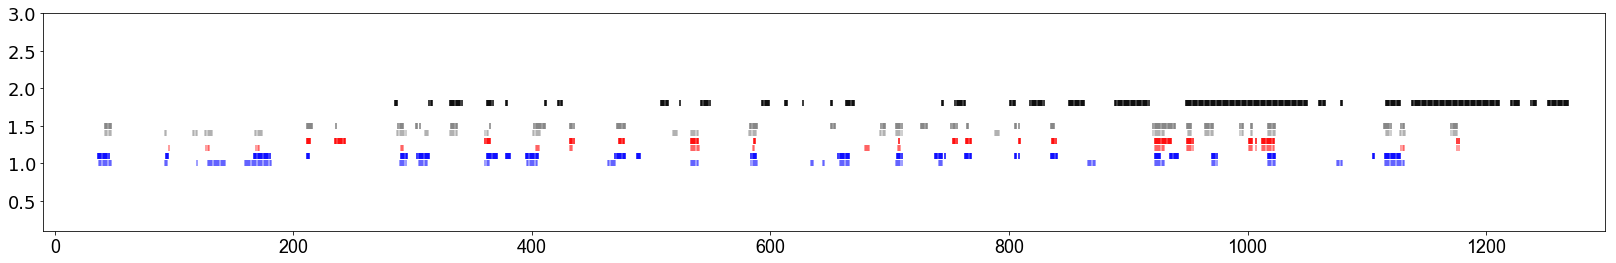

In [9]:
#Visualize overall

#number of serotypes that match 
merged_401['matched serotypes max'] = 1*(merged_401['9mers_1']==merged_401['9mers_2'])

#more minimilistic view:
plt.figure(figsize=(28,4))
plt.scatter(merged_401['overall_order'],merged_401['n hits of 7-d+u_1-bin']*1.0,c='blue',marker='|',alpha=0.5)
plt.scatter(merged_401['overall_order'],merged_401['n hits of 7-d+u_2-bin']*1.1,c='blue',marker='|')

plt.scatter(merged_402['overall_order'],merged_402['n hits of 7-d+u_1-bin']*1.2,c='red',marker='|',alpha=0.5)
plt.scatter(merged_402['overall_order'],merged_402['n hits of 7-d+u_2-bin']*1.3,c='red',marker='|')

plt.scatter(merged_404['overall_order'],merged_404['n hits of 7-d+u_1-bin']*1.4,c='grey',marker='|',alpha=0.5)
plt.scatter(merged_404['overall_order'],merged_404['n hits of 7-d+u_2-bin']*1.5,c='grey',marker='|')


plt.scatter(merged_401['overall_order'],merged_401['matched serotypes max']*0.1+1.7*(merged_401['matched serotypes max']>0),c='black',marker='|') #can do 'plot' too
plt.xlim(-10,1300)
plt.ylim(0.1, 3.)

plt.xticks(fontname='Arial')

## 9mer smoothing: SARS-CoV-2 Nucleocapsid mountain plot for HLA-DR401

in covid section


,15mers,order,source,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,...,frac_ undoped-401 post-R3 - positive,frac_ undoped-402 post-R3 - positive,frac_ undoped-404 post-R3 - positive,frac_ undoped-401 post-R3 - negative,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,hit u,hit d,hit d+u,hit mod_value
0,MSDNGPQNQRNAPRI,1,sp|P0DTC9|NCAP_WCPV,MSDNGPQNQRNAPRI,ATGTCAGACAATGGTCCTCAAAACCAACGAAATGCACCGAGGATT,0.0,0.0,0.0,2.0,2.0,...,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,False,False,False,0
1,SDNGPQNQRNAPRIT,2,sp|P0DTC9|NCAP_WCPV,SDNGPQNQRNAPRIT,TCAGATAACGGTCCTCAAAATCAAAGAAACGCCCCACGAATTACA,0.0,0.0,0.0,4.0,0.0,...,0.000000,0.000004,0.000000,0.000025,0.000000,0.000000,False,False,False,0
2,DNGPQNQRNAPRITF,3,sp|P0DTC9|NCAP_WCPV,DNGPQNQRNAPRITF,GATAACGGTCCACAAAATCAACGTAATGCTCCTAGAATCACCTTC,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000017,0.000008,0.000019,0.000014,0.000016,False,False,False,0
3,NGPQNQRNAPRITFG,4,sp|P0DTC9|NCAP_WCPV,NGPQNQRNAPRITFG,AACGGTCCACAAAACCAAAGGAACGCACCCAGAATCACTTTCGGT,0.0,0.0,0.0,5.0,0.0,...,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,False,False,False,0
4,GPQNQRNAPRITFGG,5,sp|P0DTC9|NCAP_WCPV,GPQNQRNAPRITFGG,GGGCCACAGAATCAACGTAATGCGCCTAGGATTACATTTGGTGGT,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.000000,0.000000,0.000012,0.000000,0.000000,False,False,False,0
5,PQNQRNAPRITFGGP,6,sp|P0DTC9|NCAP_WCPV,PQNQRNAPRITFGGP,CCACAAAACCAAAGAAACGCGCCGAGAATAACGTTTGGAGGGCCG,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000014,0.000000,False,False,False,0
6,QNQRNAPRITFGGPS,7,sp|P0DTC9|NCAP_WCPV,QNQRNAPRITFGGPS,CAAAATCAAAGGAACGCACCTAGAATAACATTTGGGGGTCCAAGC,0.0,0.0,0.0,6.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000007,0.000005,False,False,False,0
7,NQRNAPRITFGGPSD,8,sp|P0DTC9|NCAP_WCPV,NQRNAPRITFGGPSD,AACCAACGCAATGCGCCCAGAATTACATTTGGTGGACCTTCTGAT,0.0,0.0,0.0,0.0,2.0,...,0.000005,0.000004,0.000000,0.000000,0.000022,0.000011,False,False,False,0
8,QRNAPRITFGGPSDS,9,sp|P0DTC9|NCAP_WCPV,QRNAPRITFGGPSDS,CAGAGGAACGCACCGAGAATAACCTTTGGTGGCCCTAGCGACAGT,1.0,0.0,0.0,2.0,0.0,...,0.000011,0.000000,0.000000,0.000044,0.000000,0.000021,False,False,False,0
9,RNAPRITFGGPSDST,10,sp|P0DTC9|NCAP_WCPV,RNAPRITFGGPSDST,CGGAATGCTCCTCGAATTACATTTGGTGGTCCTTCCGACTCTACC,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000019,0.000007,0.000000,False,False,False,0


100
200
300
400


,9mers,order,source,n hits of 7-d+u,n hits of 7-d,n hits of 7-u,n hits of 7-d only,n hits of 7-u only
0,MSDNGPQNQ,1,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
1,SDNGPQNQR,2,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
2,DNGPQNQRN,3,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
3,NGPQNQRNA,4,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
4,GPQNQRNAP,5,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
5,PQNQRNAPR,6,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
6,QNQRNAPRI,7,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
7,NQRNAPRIT,8,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
8,QRNAPRITF,9,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0
9,RNAPRITFG,10,sp|P0DTC9|NCAP_WCPV,0,0,0,0,0


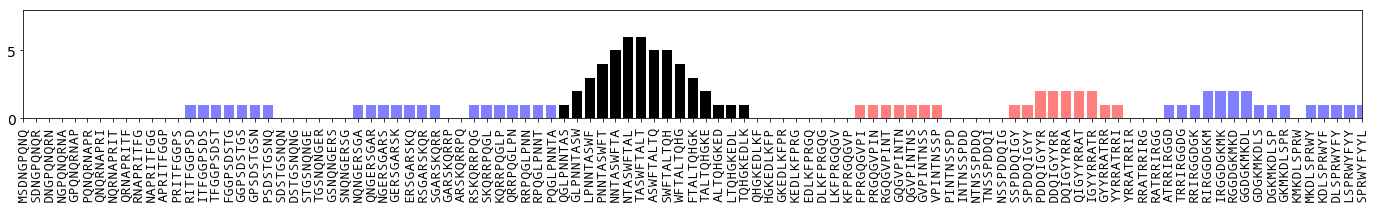

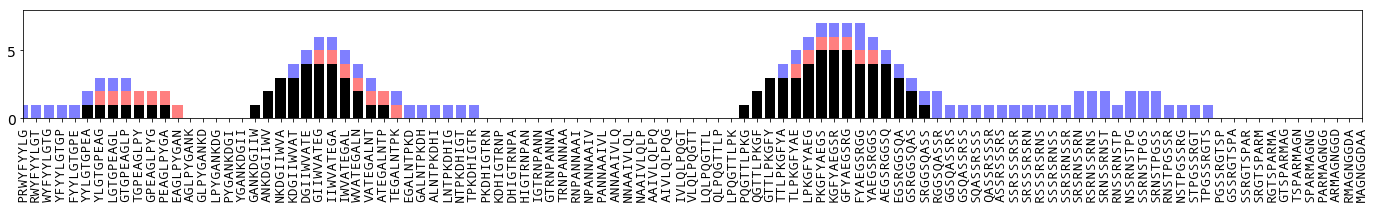

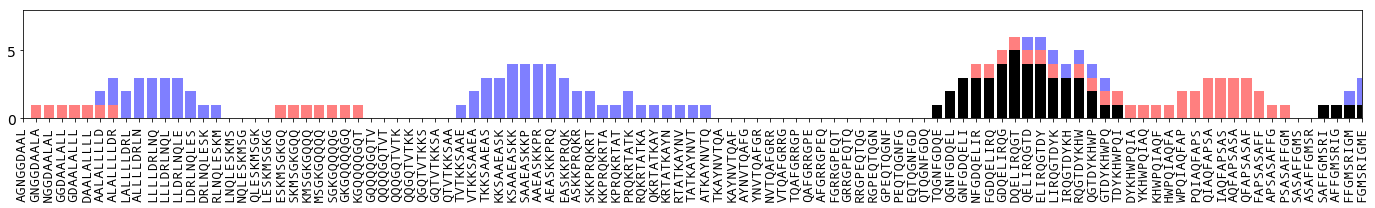

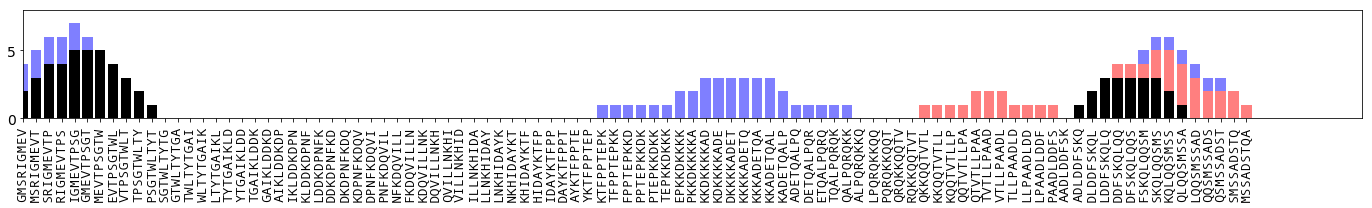

In [10]:
## Make Nucleocapsid mountain plot 

# Import yeast data
data = pd.read_csv('../twist_covid_filtered+normalized_counts.csv').fillna(0)
data.drop(columns='Unnamed: 0',inplace=True)
data.drop(columns='Unnamed: 0.1',inplace=True)
data=data[data['doped_match']!='match'] #keep only covid peptides


# read in aligned sequences - aligned via ClustalOmega
alignment = AlignIO.read('SARS-CoV+SARS-CoV-2_NCAP_clustalo-I20211008-141842-0188-61142883-p2m.clustal_num','clustal')


## SARS-CoV-2 ###
uniprot = 'sp|P0DTC9|NCAP_WCPV'
fname = '../../nCov.fasta'
data_merged_2_401, df_1mers_2_401, df_9mers_2_401 = do_it(uniprot, fname, 2,'covid',data,allele='401',kw_skipP1=True) #test no P1 processing
display(data_merged_2_401)

data_merged_2_401.to_csv('SARS-CoV-2 NCAP protein 15mers ordered-HLA-DR401 hits noted.csv')

#9mer smoothing
merged = NofSeven(data_merged_2_401, df_9mers_2_401) #actually outputs the 9mers
display(merged)

## Do on dataframe with no gaps added
# Mountain plots:

color_dict = {'n hits of 7-d+u':'black','n hits of 7-d only':'red','n hits of 7-u only':'blue'}
alpha_dict = {'n hits of 7-d+u':1,'n hits of 7-d only':0.5,'n hits of 7-u only':0.5}
legend_dict = {'n hits of 7-d+u':'Doped+Undoped','n hits of 7-d only':'Doped only','n hits of 7-u only':'Undoped only'}


for index in [0,105,210,315]:#,200,300,400,500]:
    fig, ax1 = plt.subplots(figsize=(24,2))
    
    #update font sizes for subplots
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
                 ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(14)

    # PLOT
    bottom = len(merged) * [0]
    for x in ['n hits of 7-d+u','n hits of 7-d only','n hits of 7-u only']: 
        ax1.bar(merged['9mers'],merged[x],bottom=bottom,label=legend_dict[x],color=color_dict[x],alpha=alpha_dict[x],)
        bottom+=merged[x]
    
    plt.xticks(rotation = 90)
    plt.xticks(fontname='Andale Mono')
    
    plt.ylim(0,8)
    plt.xlim(index,index+104)
    plt.show()
    
    


## 9mer smoothing: Dengue: HLA-DR401, 4 serotypes

In [11]:
## MAKE SMOOTHED BIG PICTURE DENGUE FIGURE
#edit input file:
data_dengue = pd.read_csv('twist_doped+undoped_combined_with-fractions_v2e.csv').fillna(0)


#calculate fractions for undoped rounds
for i in ['1','2','3']:
    data_dengue['401-R{}-pos_undoped_frac'.format(i)] = data_dengue['401-R{}-pos_undoped'.format(i)]/np.sum(data_dengue['401-R{}-pos_undoped'.format(i)])

data_dengue.rename(columns={'aa':'name','name':'from'}, inplace=True) #to match covid data processing
display(data_dengue)

# read in aligned sequences - aligned via ClustalOmega
alignment_dengue = AlignIO.read('clustalo-I20210910-195934-0821-95132107-p2m.clustal_num','clustal')

directory = '/Proteome Peptides/Dengue - used to generate lists'

## Dengue 1 ###
uniprot = 'sp|P17763|POLG_DEN1W'
fname = '/dengue_type1_UP000002500.fasta'
data_merged_1, df_1mers_1, df_9mers_1 = do_it(uniprot, directory+fname, 1,'dengue',data_dengue,allele='401',kw_skipP1=True)
display(df_9mers_1)
data_merged_1.to_csv('Dengue serotype1 protein 15mers ordered-HLA-DR401 hits noted.csv')
    
## Dengue 2 ###
uniprot = 'tr|O09234|O09234_DEN26'
fname = '/dengue_type2_UP000180751.fasta'
data_merged_2, df_1mers_2, df_9mers_2 = do_it(uniprot, directory+fname, 2,'dengue',data_dengue,allele='401',kw_skipP1=True)

## Dengue 3 ###
uniprot = 'sp|P27915|POLG_DEN3P'
fname = '/dengue_type3_UP000007200.fasta'
data_merged_3, df_1mers_3, df_9mers_3 = do_it(uniprot, directory+fname, 3,'dengue',data_dengue,allele='401',kw_skipP1=True)

## Dengue 4 ###
uniprot = 'sp|Q58HT7|POLG_DEN4P'
fname = '/dengue_type4_UP000000275.fasta'
data_merged_4, df_1mers_4, df_9mers_4 = do_it(uniprot, directory+fname, 4,'dengue',data_dengue,allele='401',kw_skipP1=True)



,Unnamed: 0,from,R0-401_doped-rep1,R1-401_doped-rep1,R2-401_doped-rep1,R3-401_doped-rep1,R4-401_doped-rep1,R0-402_doped-rep1,R1-402_doped-rep1,R2-402_doped-rep1,...,402-R2-pos_undoped,401-R2-neg_undoped,402-R2-neg_undoped,401-R3-pos_undoped,402-R3-pos_undoped,401-R3-neg_undoped,402-R3-neg_undoped,401-R1-pos_undoped_frac,401-R2-pos_undoped_frac,401-R3-pos_undoped_frac
0,0,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,3.0,0.0,2.0,0.0,0.000006,0.000004,0.000011
1,1,dengue_type4_15mer,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.000006,0.000000,0.000000
3,3,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,4,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0,...,0.0,4.0,1.0,0.0,0.0,2.0,0.0,0.000000,0.000000,0.000000
5,5,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,10.0,4.0,4.0,0.0,17.0,1.0,0.000023,0.000062,0.000015
6,6,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,...,0.0,2.0,2.0,1.0,0.0,2.0,0.0,0.000011,0.000000,0.000004
7,7,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,...,17.0,2.0,5.0,9.0,0.0,4.0,7.0,0.000017,0.000035,0.000033
8,8,dengue_type4_15mer,0.0,21.0,65.0,69.0,0.0,0.0,0.0,0.0,...,10.0,6.0,8.0,9.0,6.0,11.0,8.0,0.000062,0.000023,0.000033
9,9,dengue_type4_15mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,2.0,3.0,1.0,1.0,0.000011,0.000016,0.000007


in dengue section


,9mers,order,source
0,MNNQRKKTG,1,sp|P17763|POLG_DEN1W
1,NNQRKKTGR,2,sp|P17763|POLG_DEN1W
2,NQRKKTGRP,3,sp|P17763|POLG_DEN1W
3,QRKKTGRPS,4,sp|P17763|POLG_DEN1W
4,RKKTGRPSF,5,sp|P17763|POLG_DEN1W
5,KKTGRPSFN,6,sp|P17763|POLG_DEN1W
6,KTGRPSFNM,7,sp|P17763|POLG_DEN1W
7,TGRPSFNML,8,sp|P17763|POLG_DEN1W
8,GRPSFNMLK,9,sp|P17763|POLG_DEN1W
9,RPSFNMLKR,10,sp|P17763|POLG_DEN1W


in dengue section
in dengue section
in dengue section


In [12]:
#dengue version of 'smooth_each_allele', except don't need function to do for each allele (only need HLA-DR401 for figure)

merged_1_in = NofSeven(data_merged_1, df_9mers_1) #actually outputs the 9mers
merged_2_in = NofSeven(data_merged_2, df_9mers_2) #actually outputs the 9mers
merged_3_in = NofSeven(data_merged_3, df_9mers_3) #actually outputs the 9mers
merged_4_in = NofSeven(data_merged_4, df_9mers_4) #actually outputs the 9mers

merged_1 = rename_cols(merged_1_in, 1)
merged_2 = rename_cols(merged_2_in, 2)
merged_3 = rename_cols(merged_3_in, 3)
merged_4 = rename_cols(merged_4_in, 4)

merged_1 = add_gaps(merged_1, 'sp|P17763|POLG_DEN1W',  1,alignment_dengue)
merged_2 = add_gaps(merged_2, 'tr|O09234|O09234_DEN26',2,alignment_dengue)
merged_3 = add_gaps(merged_3, 'sp|P27915|POLG_DEN3P',  3,alignment_dengue)
merged_4 = add_gaps(merged_4, 'sp|Q58HT7|POLG_DEN4P',  4,alignment_dengue)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
found sequence:  sp|P17763|POLG_DEN1W
found sequence:  tr|O09234|O09234_DEN26
found sequence:  sp|P27915|POLG_DEN3P
found sequence:  sp|Q58HT7|POLG_DEN4P


In [13]:
## Merge all viruses and process
#make dataframe with order values from alignment so can order to this:
merged = pd.DataFrame({'overall_order':range(1,alignment_dengue.get_alignment_length()-7)}) # DO RANGE(0, len-7) because need amino acid at end of last peptide

#combine viruses
merged = pd.merge(left=merged, right=merged_1, left_on='overall_order',right_on='order+gaps_1',how='outer')
merged = pd.merge(left=merged, right=merged_2, left_on='overall_order',right_on='order+gaps_2',how='outer')
merged = pd.merge(left=merged, right=merged_3, left_on='overall_order',right_on='order+gaps_3',how='outer')
merged = pd.merge(left=merged, right=merged_4, left_on='overall_order',right_on='order+gaps_4',how='outer')

#binning hits - binary yes/no if >=5 of 7 are hits
for i in ['1','2','3','4']:
    merged['n hits of 7-d+u_{}-bin'.format(i)] = 1*(merged['n hits of 7-d+u_{}'.format(i)]>=5)


#number of serotypes that match -- do by using each as baseline then taking max
merged['match serotype1'] = 1*(merged['9mers_1']==merged['9mers_2']) + 1*(merged['9mers_1']==merged['9mers_3']) +1*(merged['9mers_1']==merged['9mers_4'])
merged['match serotype2'] = 1*(merged['9mers_2']==merged['9mers_1']) + 1*(merged['9mers_2']==merged['9mers_3']) +1*(merged['9mers_2']==merged['9mers_4'])
merged['match serotype3'] = 1*(merged['9mers_3']==merged['9mers_1']) + 1*(merged['9mers_3']==merged['9mers_2']) +1*(merged['9mers_3']==merged['9mers_4'])
merged['match serotype4'] = 1*(merged['9mers_4']==merged['9mers_1']) + 1*(merged['9mers_4']==merged['9mers_2']) +1*(merged['9mers_4']==merged['9mers_3'])
merged['matched serotypes max'] = merged[['match serotype1','match serotype2','match serotype3','match serotype4']].max(axis=1)
merged

#save the order as string (new column):
merged['overall_order_str'] = merged['overall_order'].astype(str) #have to convert to string in order for all values to show up on x-axis to be replaced by AAs

In [14]:
#how do positions along Dengue Serotype1 correspond to 'overall_order' positions?
#from https://www.uniprot.org/uniprot/P17763 ('PTM/Processing' section)
#last 9mer included in sequences: 
# [..114] = [LMLLPTALA]
# [..280] = [LMLVTPSMA]
# [..775] = [LYLGVMVQA]
# [..1127] =[NLVKSMVSA]
# [..1345] =[TENKIWGRK]
# [..1475] =[YFWQKKKQR]
# [..2094] =[FKEFAAGRR]
# [..2221] =[LIPEPDRQR]
# [..2244] =[LFMILTAAA] - signal peptide for NS4B
# [..2493] =[MKSLGGGRR]
# [..3392] =[ESDPEGALW]

last_9mer_dict = {114:'LMLLPTALA',280:'LMLVTPSMA',775:'LYLGVMVQA',1127:'NLVKSMVSA',
                  1345:'TENKIWGRK',1475:'YFWQKKKQR',2094:'FKEFAAGRR',
                  2221:'LIPEPDRQR',2493:'MKSLGGGRR',3392:'ESDPEGALW'}

boundaries = [[1]]
for i in [114,280,775,1127,1345,1475,2094,2221,2493,3392]:
    x = list(merged[merged['9mers_1']==last_9mer_dict[i]]['overall_order'])
    print(i, x)
    boundaries.append(x)
    
boundaries

114 [106]
280 [272]
775 [767]
1127 [1119]
1345 [1338]
1475 [1468]
2094 [2087]
2221 [2214]
2493 [2486]
3392 [3387]


[[1],
 [106],
 [272],
 [767],
 [1119],
 [1338],
 [1468],
 [2087],
 [2214],
 [2486],
 [3387]]

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text xticklabel objects>)

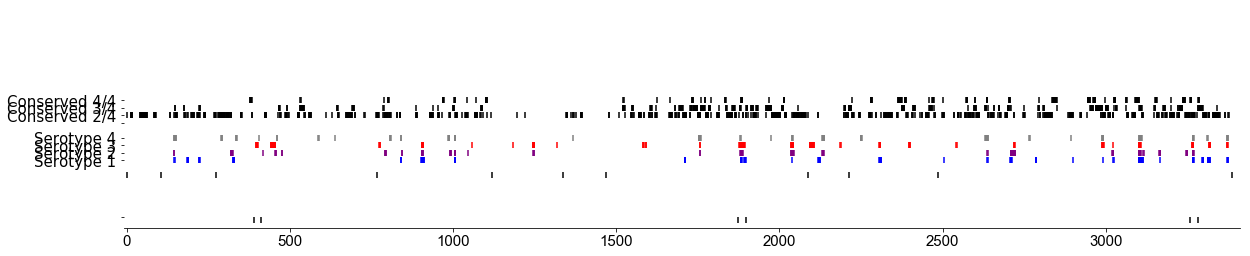

In [15]:
#Visualize overall 9mer hits and conservation

fig, ax1 = plt.subplots(figsize=(20,4))

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(15)
    
plt.scatter(merged['overall_order'],merged['n hits of 7-d+u_1-bin'], c='blue',marker='|')
plt.scatter(merged['overall_order'],merged['n hits of 7-d+u_2-bin']*1.1,c='purple',marker='|')
plt.scatter(merged['overall_order'],merged['n hits of 7-d+u_3-bin']*1.2,c='red',marker='|')
plt.scatter(merged['overall_order'],merged['n hits of 7-d+u_4-bin']*1.3,c='grey',marker='|')

plt.scatter(merged['overall_order'],merged['matched serotypes max']*0.1+1.5*(merged['matched serotypes max']>0),c='black',marker='|') #can do 'plot' too

#https://www.uniprot.org/uniprot/P17763 -- show boundaries between regions in genome
plt.scatter(boundaries,[0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8],c='black',marker='|') #plot breaks where different regions change (note 9mers, so line up is 1AA:9AA stretch)

#https://www.uniprot.org/uniprot/P17763 -- show general boundaries for where do zoom-in insets
plt.scatter([3259,3282,1873,1896,389,412],[0.2,0.2,0.2,0.2,0.2,0.2],c='black',marker='|') #plot breaks where different regions change (note 9mers, so line up is 1AA:9AA stretch)


plt.xlim(-10,3410)
plt.ylim(0.1, 3)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.yticks([0.25,1,1.1,1.2,1.3,1.5,1.6,1.7,1.8])
ax1.set_yticklabels(['','Serotype 1','Serotype 2','Serotype 3','Serotype 4','','Conserved 2/4','Conserved 3/4','Conserved 4/4']) 
plt.xticks(fontname='Arial')




# SARS-CoV-2 Spike -  with NetMHCIIpan4.0 predictions

In [16]:
## SARS-CoV-2 Spike ##
uniprot = 'sp|P0DTC2|SPIKE_WCPV'
prot_dict = SeqIO.to_dict(SeqIO.parse('../../nCov.fasta', "fasta"))#Import source protein sequences ##Dictionary of the uniprot IDs and their corresponding protein sequences

df_15mers = extract_ordered_nmers(uniprot, prot_dict, length=15)

data_merged = merge_proteomes_datasets(df_15mers,data,'covid','401')
display(data_merged)

df_1mers = extract_ordered_nmers(uniprot, prot_dict, length=1)
display(df_1mers)

df_1mers_marked = trace_hits_over_aas_dropped(df_1mers, data_merged)
display(df_1mers_marked)



## NetMHC data processing ##
#NetMHCIIpan4.0 predictions using web-interface predictions 

flanked = pd.read_csv('NetMHCIIpan4_DR401_SARS-CoV-2_Spike-flanked.csv')
flanked['name'] = flanked['Peptide'].str[1:16] #peptides with flanking sequence, so extract 15mers for merging purposes:

unflanked = pd.read_csv('NetMHCIIpan4_DR401_SARS-CoV-2_Spike.csv')
unflanked['name'] = unflanked['Peptide']


in covid section


,15mers,order,source,name,dna,count_ doped-401 R0 (doped),count_ doped-402 R0 (doped),count_ doped-404 R0 (doped),count_ doped-401 post-R1,count_ doped-402 post-R1,...,frac_ undoped-401 post-R3 - positive,frac_ undoped-402 post-R3 - positive,frac_ undoped-404 post-R3 - positive,frac_ undoped-401 post-R3 - negative,frac_ undoped-402 post-R3 - negative,frac_ undoped-404 post-R3 - negative,hit u,hit d,hit d+u,hit mod_value
0,MFVFLVLLPLVSSQC,1,sp|P0DTC2|SPIKE_WCPV,MFVFLVLLPLVSSQC,ATGTTCGTATTTTTGGTTTTATTGCCTTTGGTGTCCTCCCAATGC,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000004,0.000000,0.000006,0.000000,0.000000,True,False,False,0
1,FVFLVLLPLVSSQCV,2,sp|P0DTC2|SPIKE_WCPV,FVFLVLLPLVSSQCV,TTCGTCTTTCTCGTTTTATTACCCCTGGTAAGTTCGCAGTGCGTT,0.0,1.0,0.0,6.0,3.0,...,0.000011,0.000000,0.000000,0.000025,0.000007,0.000027,False,False,False,0
2,VFLVLLPLVSSQCVN,3,sp|P0DTC2|SPIKE_WCPV,VFLVLLPLVSSQCVN,GTGTTTCTTGTGTTACTACCTCTTGTTTCATCTCAATGTGTCAAT,0.0,0.0,0.0,3.0,0.0,...,0.000000,0.000000,0.000016,0.000000,0.000000,0.000011,False,False,False,0
3,FLVLLPLVSSQCVNL,4,sp|P0DTC2|SPIKE_WCPV,FLVLLPLVSSQCVNL,TTTCTTGTGTTACTTCCTCTCGTGAGTTCTCAGTGTGTTAACTTA,0.0,0.0,1.0,25.0,3.0,...,0.000011,0.000008,0.000000,0.000031,0.000029,0.000005,False,True,False,0
4,LVLLPLVSSQCVNLT,5,sp|P0DTC2|SPIKE_WCPV,LVLLPLVSSQCVNLT,CTAGTGCTGCTACCATTGGTCTCCTCACAATGTGTCAATTTAACT,0.0,0.0,0.0,6.0,1.0,...,0.000000,0.000000,0.000000,0.000087,0.000014,0.000037,False,True,False,0
5,VLLPLVSSQCVNLTT,6,sp|P0DTC2|SPIKE_WCPV,VLLPLVSSQCVNLTT,GTCTTACTACCTCTTGTGAGTTCACAATGCGTCAACCTTACTACA,0.0,0.0,0.0,14.0,21.0,...,0.000163,0.000063,0.000121,0.000311,0.000086,0.000112,True,True,True,7
6,LLPLVSSQCVNLTTR,7,sp|P0DTC2|SPIKE_WCPV,LLPLVSSQCVNLTTR,CTCCTTCCATTAGTCAGCTCCCAGTGCGTTAACTTGACTACTAGA,0.0,0.0,0.0,12.0,39.0,...,0.000081,0.000038,0.000070,0.000249,0.000079,0.000155,False,True,False,0
7,LPLVSSQCVNLTTRT,8,sp|P0DTC2|SPIKE_WCPV,LPLVSSQCVNLTTRT,TTGCCTTTAGTTAGTTCACAATGCGTCAATTTGACGACCAGGACG,0.0,0.0,0.0,6.0,26.0,...,0.000103,0.000059,0.000090,0.000224,0.000195,0.000177,False,True,False,0
8,PLVSSQCVNLTTRTQ,9,sp|P0DTC2|SPIKE_WCPV,PLVSSQCVNLTTRTQ,CCATTAGTTAGTAGCCAATGTGTTAACTTAACAACCAGAACTCAA,0.0,0.0,0.0,9.0,5.0,...,0.000027,0.000025,0.000062,0.000149,0.000130,0.000166,False,True,False,0
9,LVSSQCVNLTTRTQL,10,sp|P0DTC2|SPIKE_WCPV,LVSSQCVNLTTRTQL,CTGGTCAGCTCACAGTGCGTGAACTTGACTACAAGGACTCAACTA,0.0,0.0,0.0,10.0,22.0,...,0.000033,0.000155,0.000047,0.000112,0.000303,0.000139,False,True,False,0


,1mers,order,source
0,M,1,sp|P0DTC2|SPIKE_WCPV
1,F,2,sp|P0DTC2|SPIKE_WCPV
2,V,3,sp|P0DTC2|SPIKE_WCPV
3,F,4,sp|P0DTC2|SPIKE_WCPV
4,L,5,sp|P0DTC2|SPIKE_WCPV
5,V,6,sp|P0DTC2|SPIKE_WCPV
6,L,7,sp|P0DTC2|SPIKE_WCPV
7,L,8,sp|P0DTC2|SPIKE_WCPV
8,P,9,sp|P0DTC2|SPIKE_WCPV
9,L,10,sp|P0DTC2|SPIKE_WCPV


,1mers,order,source,mod=1,mod=2,mod=3,mod=4,mod=5,mod=6,mod=7,mod=8,mod=9,mod=10,mod=11,mod=12,mod=13,mod=14,mod=15,order_str
0,M,1,sp|P0DTC2|SPIKE_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,F,2,sp|P0DTC2|SPIKE_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,V,3,sp|P0DTC2|SPIKE_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,F,4,sp|P0DTC2|SPIKE_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,L,5,sp|P0DTC2|SPIKE_WCPV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,V,6,sp|P0DTC2|SPIKE_WCPV,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,L,7,sp|P0DTC2|SPIKE_WCPV,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,L,8,sp|P0DTC2|SPIKE_WCPV,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
8,P,9,sp|P0DTC2|SPIKE_WCPV,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
9,L,10,sp|P0DTC2|SPIKE_WCPV,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


in netmhc section


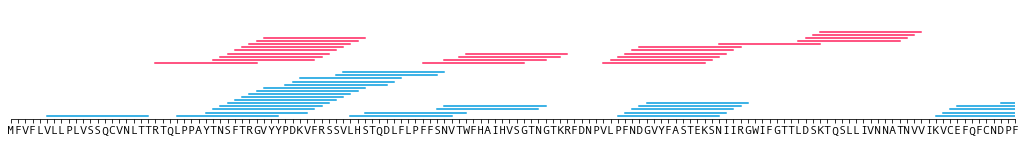

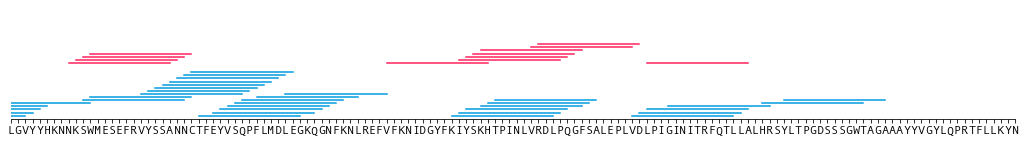

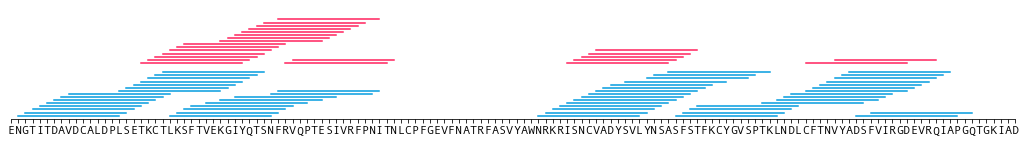

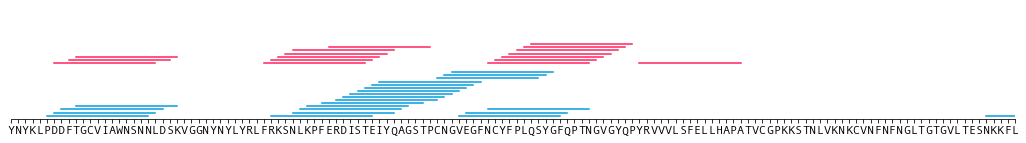

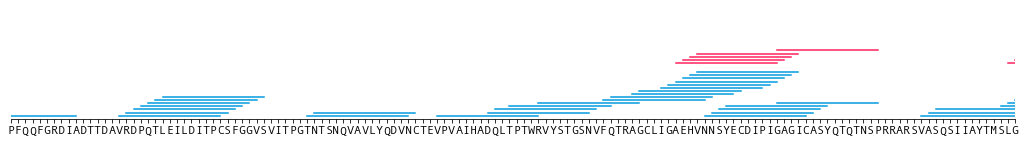

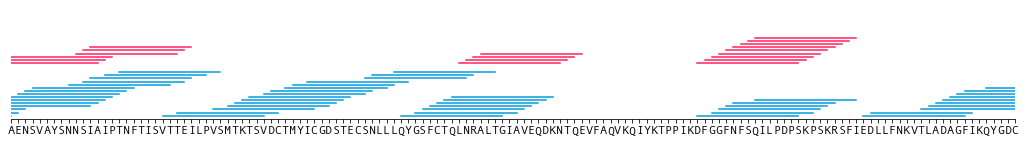

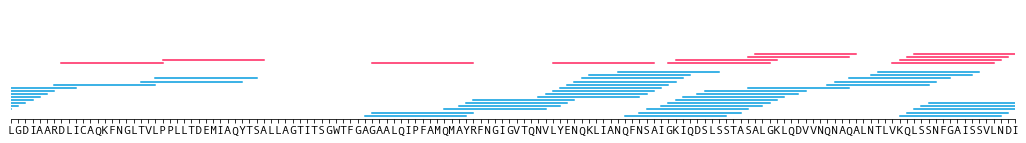

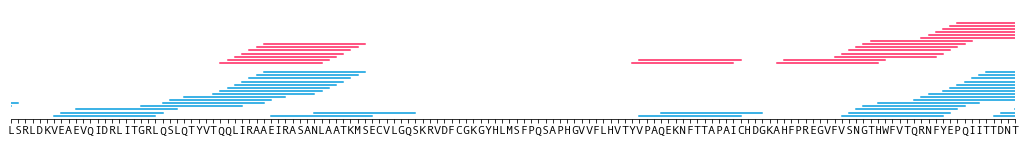

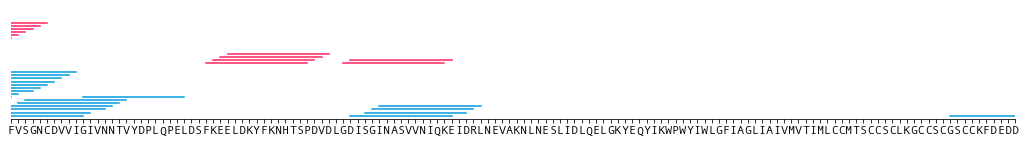

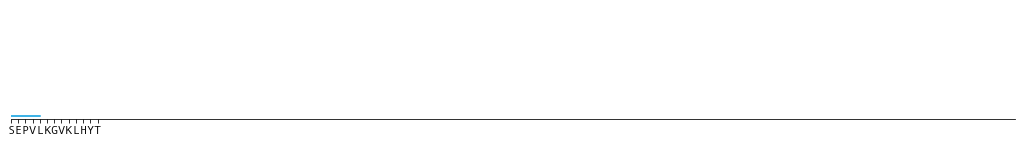

In [17]:
#plot:
for netmhc in [flanked]:

    #make 1mer dataframe for Spike protein again
    uniprot = 'sp|P0DTC2|SPIKE_WCPV'
    prot_dict = SeqIO.to_dict(SeqIO.parse('../../nCov.fasta', "fasta"))#Import source protein sequences ##Dictionary of the uniprot IDs and their corresponding protein sequences
    df_15mers = extract_ordered_nmers(uniprot, prot_dict, length=15)
    df_1mers = extract_ordered_nmers(uniprot, prot_dict, length=1)

    
    data_merged_netmhc = merge_proteomes_datasets(df_15mers,netmhc,'netmhc','401')
    df_1mers_marked_netmhc = trace_hits_over_aas_dropped(df_1mers, data_merged_netmhc)


    plt.rcParams.update({'font.size': 12})
    for index in [0,140,280,420,560,700,840,980,1120,1260]:
        fig, ax1 = plt.subplots(figsize=(18,2))
        for i in range(1,16): 
            plt.plot(df_1mers_marked['order_str'],df_1mers_marked['mod={}'.format(str(i))], c='#009ADE')#,marker='_')#,s=100)
            plt.plot(df_1mers_marked_netmhc['order_str'],df_1mers_marked_netmhc['mod={}'.format(str(i))]+17, c='#FF1F5B')#,marker='_')
            
        ax1.set_xticklabels(df_1mers_marked['1mers']) ## label with amino acid

        plt.xlim(index,index+139)#99)#139)
        plt.ylim(0, 35)

        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        plt.yticks([])  
        plt.xticks(fontname='Andale Mono')
        plt.show()
    





# Make version that is specific to regions and only shows peptides that contain a given 9mer 

### SARS-CoV-1/2

In [18]:
## ADAPTED FOR TARGETED FIGURES
#function to call other functions: for both Dengue and Covid:
def do_it_targeted(uniprot, fname,serotype,virus,data,mhc,directory=''):
    prot_dict = SeqIO.to_dict(SeqIO.parse(directory+fname, "fasta"))#Import source protein sequences ##Dictionary of the uniprot IDs and their corresponding protein sequences
    df_15mers = extract_ordered_nmers(uniprot, prot_dict, length=15) #15mers
    data_merged = merge_proteomes_datasets(df_15mers,data,virus,mhc) 
    
    #blank everything except the desired area:
    data_merged.loc[~((data_merged['order']>serotype_blank_min[serotype])&(data_merged['order']<serotype_blank_max[serotype])),'hit mod_value'] = 0
    
    df_1mers = extract_ordered_nmers(uniprot, prot_dict, length=1) #1mers
    df_1mers = trace_hits_over_aas_dropped(df_1mers, data_merged) 
    
    df_1mers = rename_cols(df_1mers, serotype)
    return data_merged, df_1mers


CoV-1 Spike
in covid section
in covid section
in covid section
CoV-2 Spike
in covid section
in covid section
in covid section
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P0DTC2|SPIKE_WCPV
here


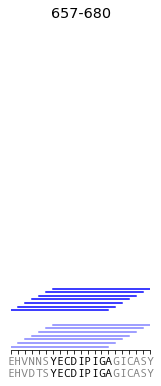

CoV-1 Spike
in covid section
in covid section
in covid section
CoV-2 Spike
in covid section
in covid section
in covid section
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P0DTC2|SPIKE_WCPV
here


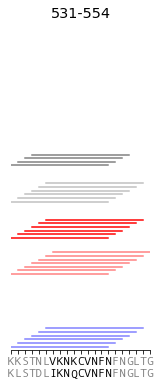

CoV-1 Spike
in covid section
in covid section
in covid section
CoV-2 Spike
in covid section
in covid section
in covid section
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P59594|SPIKE_CVHSA
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P0DTC2|SPIKE_WCPV
found sequence:  sp|P0DTC2|SPIKE_WCPV
here


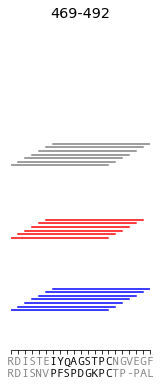

In [19]:
## SARS-CoV-2 Spike ##
def everything_else_covid(narrow_kw=''):
    # narrow_kw = 'narrow' will make the X-dimension length right for non-linker peptides
    
    ## SARS-CoV Spike ##
    print('CoV-1 Spike')
    uniprot = 'sp|P59594|SPIKE_CVHSA'
    fname = '../../uniprot-proteome_UP000000354 SARS-CoV-1.fasta'
   
    data_merged_1_401, df_1mers_1_401 = do_it_targeted(uniprot, fname, 1,'covid',data,'401')
    data_merged_1_402, df_1mers_1_402 = do_it_targeted(uniprot, fname, 1,'covid',data,'402')
    data_merged_1_404, df_1mers_1_404 = do_it_targeted(uniprot, fname, 1,'covid',data,'404')

    ## SARS-CoV-2 Spike ##
    print('CoV-2 Spike')
    uniprot = 'sp|P0DTC2|SPIKE_WCPV'
    fname = '../../nCov.fasta'
    
    data_merged_2_401, df_1mers_2_401 = do_it_targeted(uniprot, fname, 2,'covid',data,'401')
    data_merged_2_402, df_1mers_2_402 = do_it_targeted(uniprot, fname, 2,'covid',data,'402')
    data_merged_2_404, df_1mers_2_404 = do_it_targeted(uniprot, fname, 2,'covid',data,'404')

    
    
    # read in aligned sequences - aligned via ClustalOmega
    alignment = AlignIO.read('SARS-CoV+SARS-CoV-2_Spike_clustalo-I20211008-141806-0217-21876811-p1m.clustal_num','clustal')


    # find where there are gaps in alignment and add gaps in the ordered dataframe
    df_1mers_1_401 = add_gaps(df_1mers_1_401, 'sp|P59594|SPIKE_CVHSA',1,alignment)
    df_1mers_1_402 = add_gaps(df_1mers_1_402, 'sp|P59594|SPIKE_CVHSA',1,alignment)
    df_1mers_1_404 = add_gaps(df_1mers_1_404, 'sp|P59594|SPIKE_CVHSA',1,alignment)
    df_1mers_2_401 = add_gaps(df_1mers_2_401, 'sp|P0DTC2|SPIKE_WCPV' ,2,alignment)
    df_1mers_2_402 = add_gaps(df_1mers_2_402, 'sp|P0DTC2|SPIKE_WCPV' ,2,alignment)
    df_1mers_2_404 = add_gaps(df_1mers_2_404, 'sp|P0DTC2|SPIKE_WCPV' ,2,alignment)

    
    df_1mers_1_401 = rename_cols(df_1mers_1_401, 401)
    df_1mers_1_402 = rename_cols(df_1mers_1_402, 402)
    df_1mers_1_404 = rename_cols(df_1mers_1_404, 404)
    df_1mers_2_401 = rename_cols(df_1mers_2_401, 401)
    df_1mers_2_402 = rename_cols(df_1mers_2_402, 402)
    df_1mers_2_404 = rename_cols(df_1mers_2_404, 404)

    ## Merge all 4 serotypes and process
    #make dataframe with all order values so can order to this:
    merged = pd.DataFrame({'overall_order':range(1,alignment.get_alignment_length())}) 
    
    
    #combine all 4 serotypes
    merged = pd.merge(left=merged, right=df_1mers_1_401, left_on='overall_order',right_on='order+gaps_1_401',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_1_402, left_on='overall_order',right_on='order+gaps_1_402',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_1_404, left_on='overall_order',right_on='order+gaps_1_404',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_2_401, left_on='overall_order',right_on='order+gaps_2_401',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_2_402, left_on='overall_order',right_on='order+gaps_2_402',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_2_404, left_on='overall_order',right_on='order+gaps_2_404',how='outer')

    
    # combine amino acids for making X-tick labels that are basically the alignment
    for i in [1,2]:
        for mhc in [401,402,404]:
            merged['1mers_'+str(i)+'_'+str(mhc)].fillna('-',inplace=True)
    merged['combo_P1'] = merged['1mers_2_401']+"\n"+ merged['1mers_1_401']

    #save the order as string (new column):
    merged['overall_order_str'] = merged['overall_order'].astype(str) #have to convert to string in order for all values to show up on x-axis to be replaced by AAs

    
    #Color core in black, rest in grey 
    merged['color'] = 'grey'
    merged.loc[((merged['overall_order']>=serotype_blank_min['overall']+9)&(merged['overall_order']<=serotype_blank_max['overall']-6)),'color'] = 'black'


    # PLOT #####
    plt.rcParams.update({'font.size': 12})

    for index in [serotype_blank_min['index']]:
        print('here')
        fig, ax1 = plt.subplots(figsize=(2.5,6))
                
        for i in range(1,16):

            plt.plot(merged['overall_order_str'], merged['mod={}_1_401'.format(str(i))]+0 , c='blue',alpha=0.5)
            plt.plot(merged['overall_order_str'], merged['mod={}_2_401'.format(str(i))]+10, c='blue')
            plt.plot(merged['overall_order_str'], merged['mod={}_1_402'.format(str(i))]+20, c='red',alpha=0.5)
            plt.plot(merged['overall_order_str'], merged['mod={}_2_402'.format(str(i))]+30, c='red')
            plt.plot(merged['overall_order_str'], merged['mod={}_1_404'.format(str(i))]+40, c='grey',alpha=0.5)
            plt.plot(merged['overall_order_str'], merged['mod={}_2_404'.format(str(i))]+50, c='grey')
            

        ax1.set_xticklabels(merged['combo_P1']) ## label with amino acid

        if narrow_kw == 'narrow':
            plt.xlim(index,index+20)
        else:
            plt.xlim(index,index+23)

                
        plt.ylim(0, 90)

        for xtick, color in zip(ax1.get_xticklabels(),merged['color']):
            xtick.set_color(color)

        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        plt.yticks([])  
        plt.xticks(fontname='Andale Mono')
        plt.title(str(index)+"-"+str(index+23))

        plt.show()

    return
    

### excludes the overlapping linker variants:
serotype_blank_min = {1:636+3,2:650+3,'overall':655,'index':654+3}
serotype_blank_max = {1:647,2:661,'overall':678}
everything_else_covid('narrow')

serotype_blank_min = {1:510+3,2:524+3,'overall':529,'index':528+3}
serotype_blank_max = {1:521,2:535,'overall':552}
everything_else_covid('narrow')

serotype_blank_min = {1:449+3,2:462+3,'overall':467,'index':466+3}
serotype_blank_max = {1:459,2:473,'overall':490}
everything_else_covid('narrow')

### Dengue

In [20]:
def everything_else(narrow_kw=''):
    #new:
    directory = '/Proteome Peptides/Dengue - used to generate lists'

    ## Dengue 1 ###
    uniprot = 'sp|P17763|POLG_DEN1W'
    fname = '/dengue_type1_UP000002500.fasta'
    data_merged_1, df_1mers_1 = do_it_targeted(uniprot, fname, 1,'dengue',data_dengue,'401',directory)

    ## Dengue 2 ###
    uniprot = 'tr|O09234|O09234_DEN26'
    fname = '/dengue_type2_UP000180751.fasta'
    data_merged_2, df_1mers_2 = do_it_targeted(uniprot, fname, 2,'dengue',data_dengue,'401',directory)
    
    ## Dengue 3 ###
    uniprot = 'sp|P27915|POLG_DEN3P'
    fname = '/dengue_type3_UP000007200.fasta'
    data_merged_3, df_1mers_3 = do_it_targeted(uniprot, fname, 3,'dengue',data_dengue,'401',directory)

    ## Dengue 4 ###
    uniprot = 'sp|Q58HT7|POLG_DEN4P'
    fname = '/dengue_type4_UP000000275.fasta'
    data_merged_4, df_1mers_4 = do_it_targeted(uniprot, fname, 4,'dengue',data_dengue,'401',directory)



    # find where there are gaps in alignment and add gaps in the ordered dataframe
    df_1mers_1 = add_gaps(df_1mers_1, 'sp|P17763|POLG_DEN1W', 1, alignment_dengue)
    df_1mers_2 = add_gaps(df_1mers_2, 'tr|O09234|O09234_DEN26',2,alignment_dengue)
    df_1mers_3 = add_gaps(df_1mers_3, 'sp|P27915|POLG_DEN3P', 3, alignment_dengue)
    df_1mers_4 = add_gaps(df_1mers_4, 'sp|Q58HT7|POLG_DEN4P', 4, alignment_dengue)



    ## Merge all 4 serotypes and process

    #make dataframe with all order values so can order to this:
    merged = pd.DataFrame({'overall_order':range(1,alignment_dengue.get_alignment_length())}) 

    #combine all 4 serotypes
    merged = pd.merge(left=merged, right=df_1mers_1, left_on='overall_order',right_on='order+gaps_1',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_2, left_on='overall_order',right_on='order+gaps_2',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_3, left_on='overall_order',right_on='order+gaps_3',how='outer')
    merged = pd.merge(left=merged, right=df_1mers_4, left_on='overall_order',right_on='order+gaps_4',how='outer')


    # combine amino acids for making X-tick labels that are basically the alignment
    for i in [1,2,3,4]:
        merged['1mers_'+str(i)].fillna('-',inplace=True)
    merged['combo_P1'] = merged['1mers_4']+"\n"+ merged['1mers_3']+"\n"+ merged['1mers_2']+"\n"+ merged['1mers_1']

    #save the order as string (new column):
    merged['overall_order_str'] = merged['overall_order'].astype(str) #have to convert to string in order for all values to show up on x-axis to be replaced by AAs

    
    #Color core in black, rest in grey 
    merged['color'] = 'grey'
    merged.loc[((merged['overall_order']>=serotype_blank_min['overall']+9)&(merged['overall_order']<=serotype_blank_max['overall']-6)),'color'] = 'black'

    
    # PLOT #####
    plt.rcParams.update({'font.size': 14})

    color_dict = {1:'blue',
                  2:'purple',
                  3:'red',
                  4:'grey'
                 }

    for index in [serotype_blank_min['index']]:
        fig, ax1 = plt.subplots(figsize=(3,5))
        for serotype in [1,2,3,4]:
            for i in range(1,16):
                temp = merged['mod={}_{}'.format(str(i), str(serotype))]+(serotype-1)*10
                plt.plot(merged['overall_order_str'],temp, c=color_dict[serotype])#,marker='_')#,s=100)


        ax1.set_xticklabels(merged['combo_P1']) ## label with amino acid


        if narrow_kw=='narrow':
            plt.xlim(index,index+20)
        else:
            plt.xlim(index,index+23)
        plt.ylim(0, 60)

        for xtick, color in zip(ax1.get_xticklabels(),merged['color']):
            xtick.set_color(color)

        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        plt.yticks([])  
        plt.xticks(fontname='Andale Mono')
        plt.title(str(index)+"-"+str(index+23))

        plt.show()

    
    return
 

in dengue section
in dengue section
in dengue section
in dengue section
found sequence:  sp|P17763|POLG_DEN1W
found sequence:  tr|O09234|O09234_DEN26
found sequence:  sp|P27915|POLG_DEN3P
found sequence:  sp|Q58HT7|POLG_DEN4P


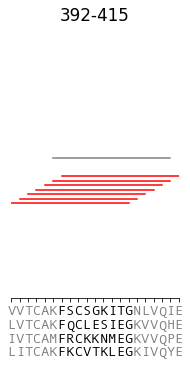

in dengue section
in dengue section
in dengue section
in dengue section
found sequence:  sp|P17763|POLG_DEN1W
found sequence:  tr|O09234|O09234_DEN26
found sequence:  sp|P27915|POLG_DEN3P
found sequence:  sp|Q58HT7|POLG_DEN4P


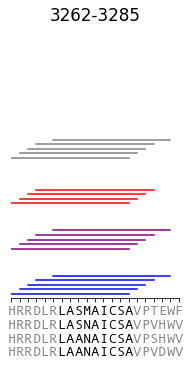

in dengue section
in dengue section
in dengue section
in dengue section
found sequence:  sp|P17763|POLG_DEN1W
found sequence:  tr|O09234|O09234_DEN26
found sequence:  sp|P27915|POLG_DEN3P
found sequence:  sp|Q58HT7|POLG_DEN4P


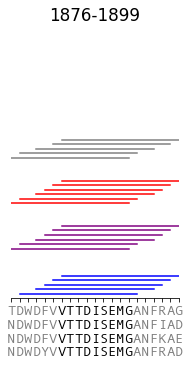

In [21]:
## Narrow these so don't include linker sequences
#finagle these and check with overall visualization
#'overall' controls what AAs are different colors
serotype_blank_min = {1:390+3,2:390+3,3:390+2,4:388+3,'overall':390,'index':389+3}
serotype_blank_max = {1:401,2:401,3:401,4:399,'overall':413}
everything_else('narrow')

serotype_blank_min = {1:3256+3,2:3255+3,3:3254+3,4:3252+3,'overall':3260,'index':3259+3}
serotype_blank_max = {1:3267,2:3266,3:3265,4:3263,'overall':3283}
everything_else('narrow')

serotype_blank_min = {1:1872+3,2:1871+3,3:1870+3,4:1870+3,'overall':1874,'index':1873+3}
serotype_blank_max = {1:1883,2:1883,3:1881,4:1881,'overall':1897}
everything_else('narrow')